In [237]:
import numpy as np

from scipy.stats import norm

import matplotlib.pyplot as plt

# Trialwise strategy

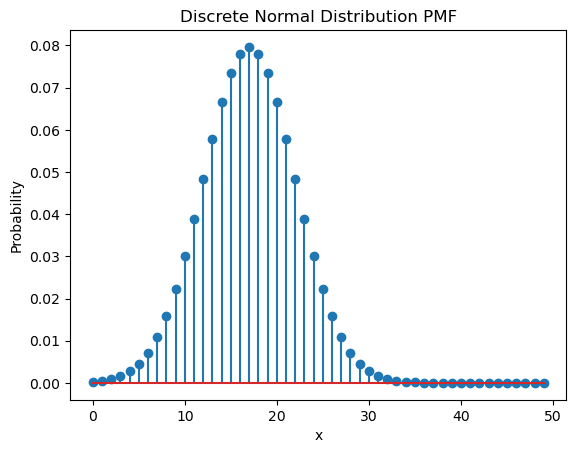

In [238]:
mu = 17
sd = 5
reward = 1.


def normal_distribution_discrete_pdf(x, mu, sd):
    # Make sure x is an integer (give warning otherwise)
    x = np.floor(x)


    return norm.cdf(x + 0.5, mu, sd) - norm.cdf(x - 0.5, mu, sd)

def normal_distribution_discrete_cdf(x, mu, sd):
    # Make sure x is an integer
    x = np.floor(x)

    return np.clip(norm.cdf(x + 0.5, mu, sd), 1e-6, 1-1e-6)

x = np.arange(50)
plt.stem(x, normal_distribution_discrete_pdf(x, mu, sd))
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Discrete Normal Distribution PMF')
plt.show()

## Strategy 1: Get expected utility for every possible number of pumps beforehand

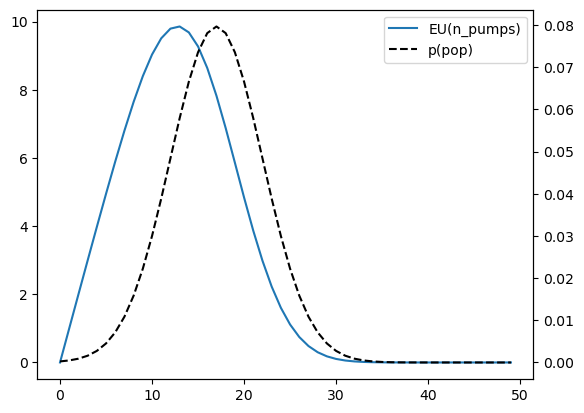

In [239]:
p_pop = normal_distribution_discrete_cdf(x, mu, sd)

reward = 1.
alpha = .5

eu = (1-p_pop) * x * reward**alpha

# Create the plot
fig, ax = plt.subplots()
ax.plot(x, eu, label='EU(n_pumps)')

twin_ax = ax.twinx()
twin_ax.plot(x, normal_distribution_discrete_pdf(x, mu, sd), c='k', ls='--', label='p(pop)')

# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = twin_ax.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='best')

plt.show()


### Strategy 2: Get expected utility for the option to continue or to bank (EU_bank = 0.0)

(-5.0, 2.0)

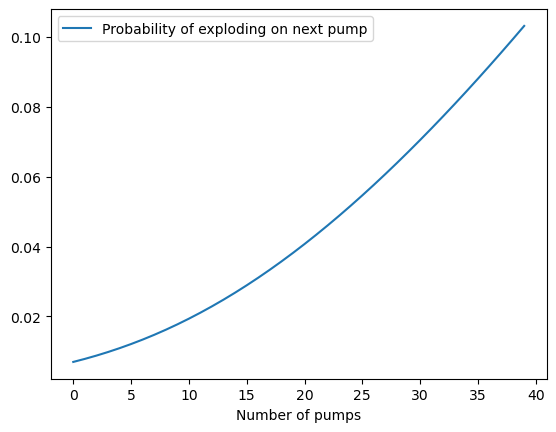

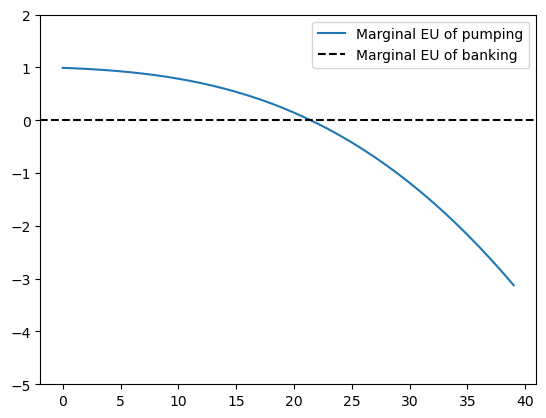

In [240]:
mu = 25
sd = 15

x = np.arange(40)


alpha = 1.0
lambd = 1.0



p_pop_on_pump = normal_distribution_discrete_pdf(x, mu, sd) / \
      (1-normal_distribution_discrete_cdf(x, mu, sd))

p_pop_on_pump = np.min([p_pop_on_pump, np.ones_like(p_pop_on_pump)], axis=0)

plt.plot(x, p_pop_on_pump, label='Probability of exploding on next pump')
plt.xlabel('Number of pumps')
plt.legend()

plt.figure()


eu_pump = (1-p_pop_on_pump) * reward**alpha - lambd * p_pop_on_pump * (x*reward)**alpha

plt.plot(x, eu_pump, label='Marginal EU of pumping')
plt.axhline(0.0, c='k', ls='--', label='Marginal EU of banking')

plt.legend()

plt.ylim(-5, 2)

# How to learn posterior from balloon pops

In [241]:
possible_mus = np.arange(5, 30)
possible_sds = np.linspace(1, 15, 30)

# FLAT prior
prior = np.ones((len(possible_mus), len(possible_sds)))

# Normalize to integrate to 1
prior = prior / np.trapz(prior, possible_mus, axis=0)[np.newaxis, :]
prior = prior / np.trapz(prior, possible_sds, axis=1)[:, np.newaxis]

In [242]:
def get_likelihood(bursted, x, mu, sd):
    p_pop_on_pump = normal_distribution_discrete_pdf(x, mu, sd) / \
      (1-normal_distribution_discrete_cdf(x, mu, sd))

    p_pop_on_pump = np.min([p_pop_on_pump, np.ones_like(p_pop_on_pump)], axis=0)

    return np.where(bursted, p_pop_on_pump, 1-p_pop_on_pump)

    # return p_pop_on_pump[bursted]

# Likelihood of observing a pop over different mus and sigmas

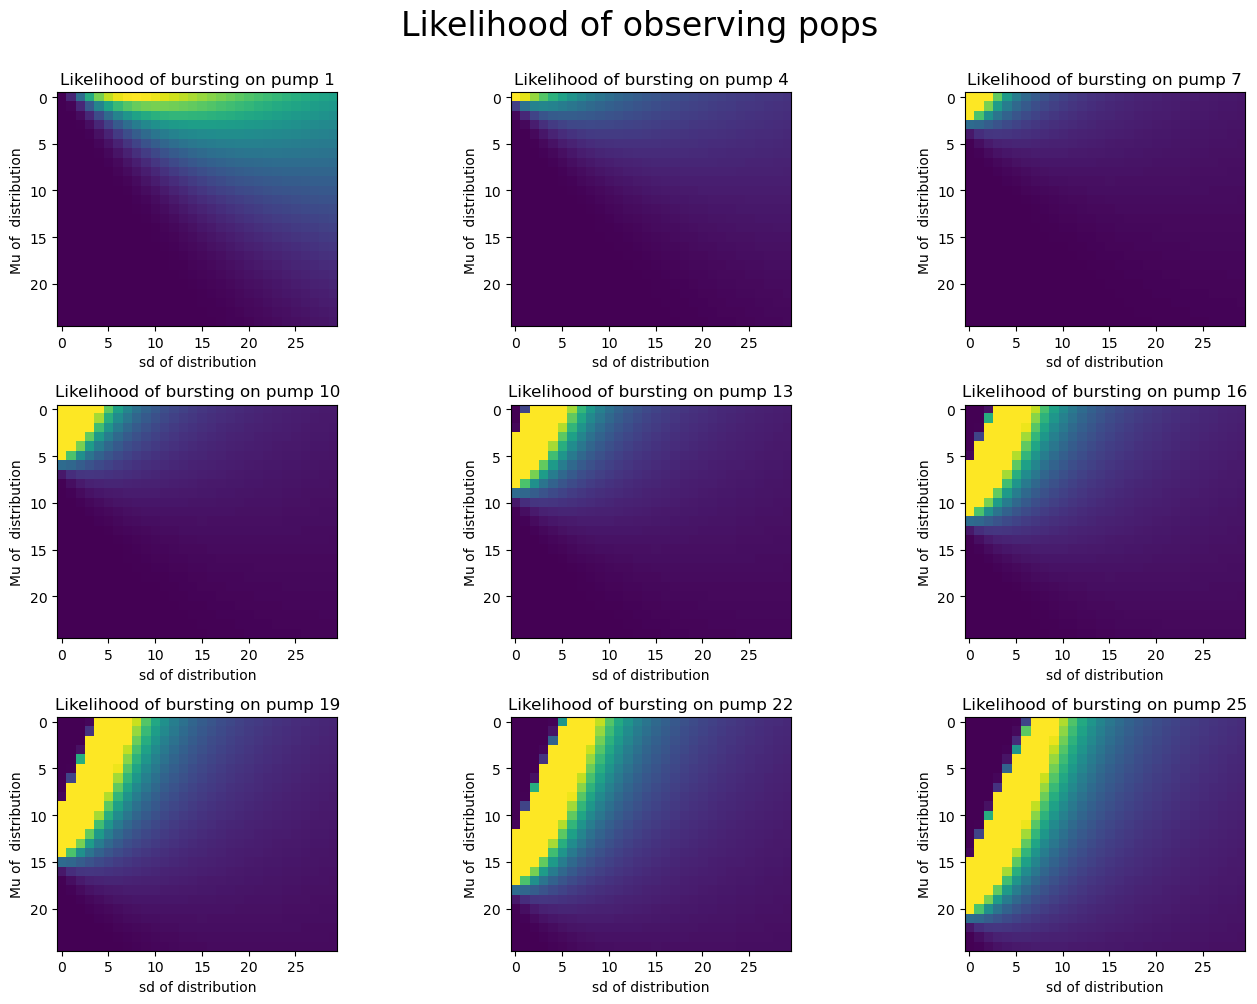

In [243]:
plt.figure(figsize=(14, 10))

plt.suptitle('Likelihood of observing pops', y=1.0, fontsize=24)

for i, n in enumerate(range(1, 27, 3)):

    plt.subplot(3,3,i+1)

    ll = get_likelihood([True], n, possible_mus[:, np.newaxis], possible_sds[np.newaxis, :])
    plt.imshow(ll)
    plt.title(f'Likelihood of bursting on pump {n}')
    plt.ylabel('Mu of  distribution')
    plt.xlabel('sd of distribution')

plt.tight_layout()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_39351/1458080474.py:28: RuntimeWarning: divide by zero encountered in divide
  p_pop_on_pump = normal_distribution_discrete_pdf(x, mus, sds) / \


Bursted after 19 pumps
Bursted after 28 pumps
Bursted after 17 pumps
Bursted after 34 pumps
Bursted after 23 pumps
Bursted after 25 pumps
Bursted after 20 pumps
Bursted after 31 pumps
Bursted after 32 pumps
Bursted after 24 pumps
Bursted after 28 pumps
Bursted after 21 pumps
Bursted after 15 pumps
Bursted after 28 pumps
Bursted after 27 pumps
Bursted after 17 pumps
Bursted after 22 pumps
Bursted after 29 pumps
Bursted after 19 pumps
Bursted after 30 pumps


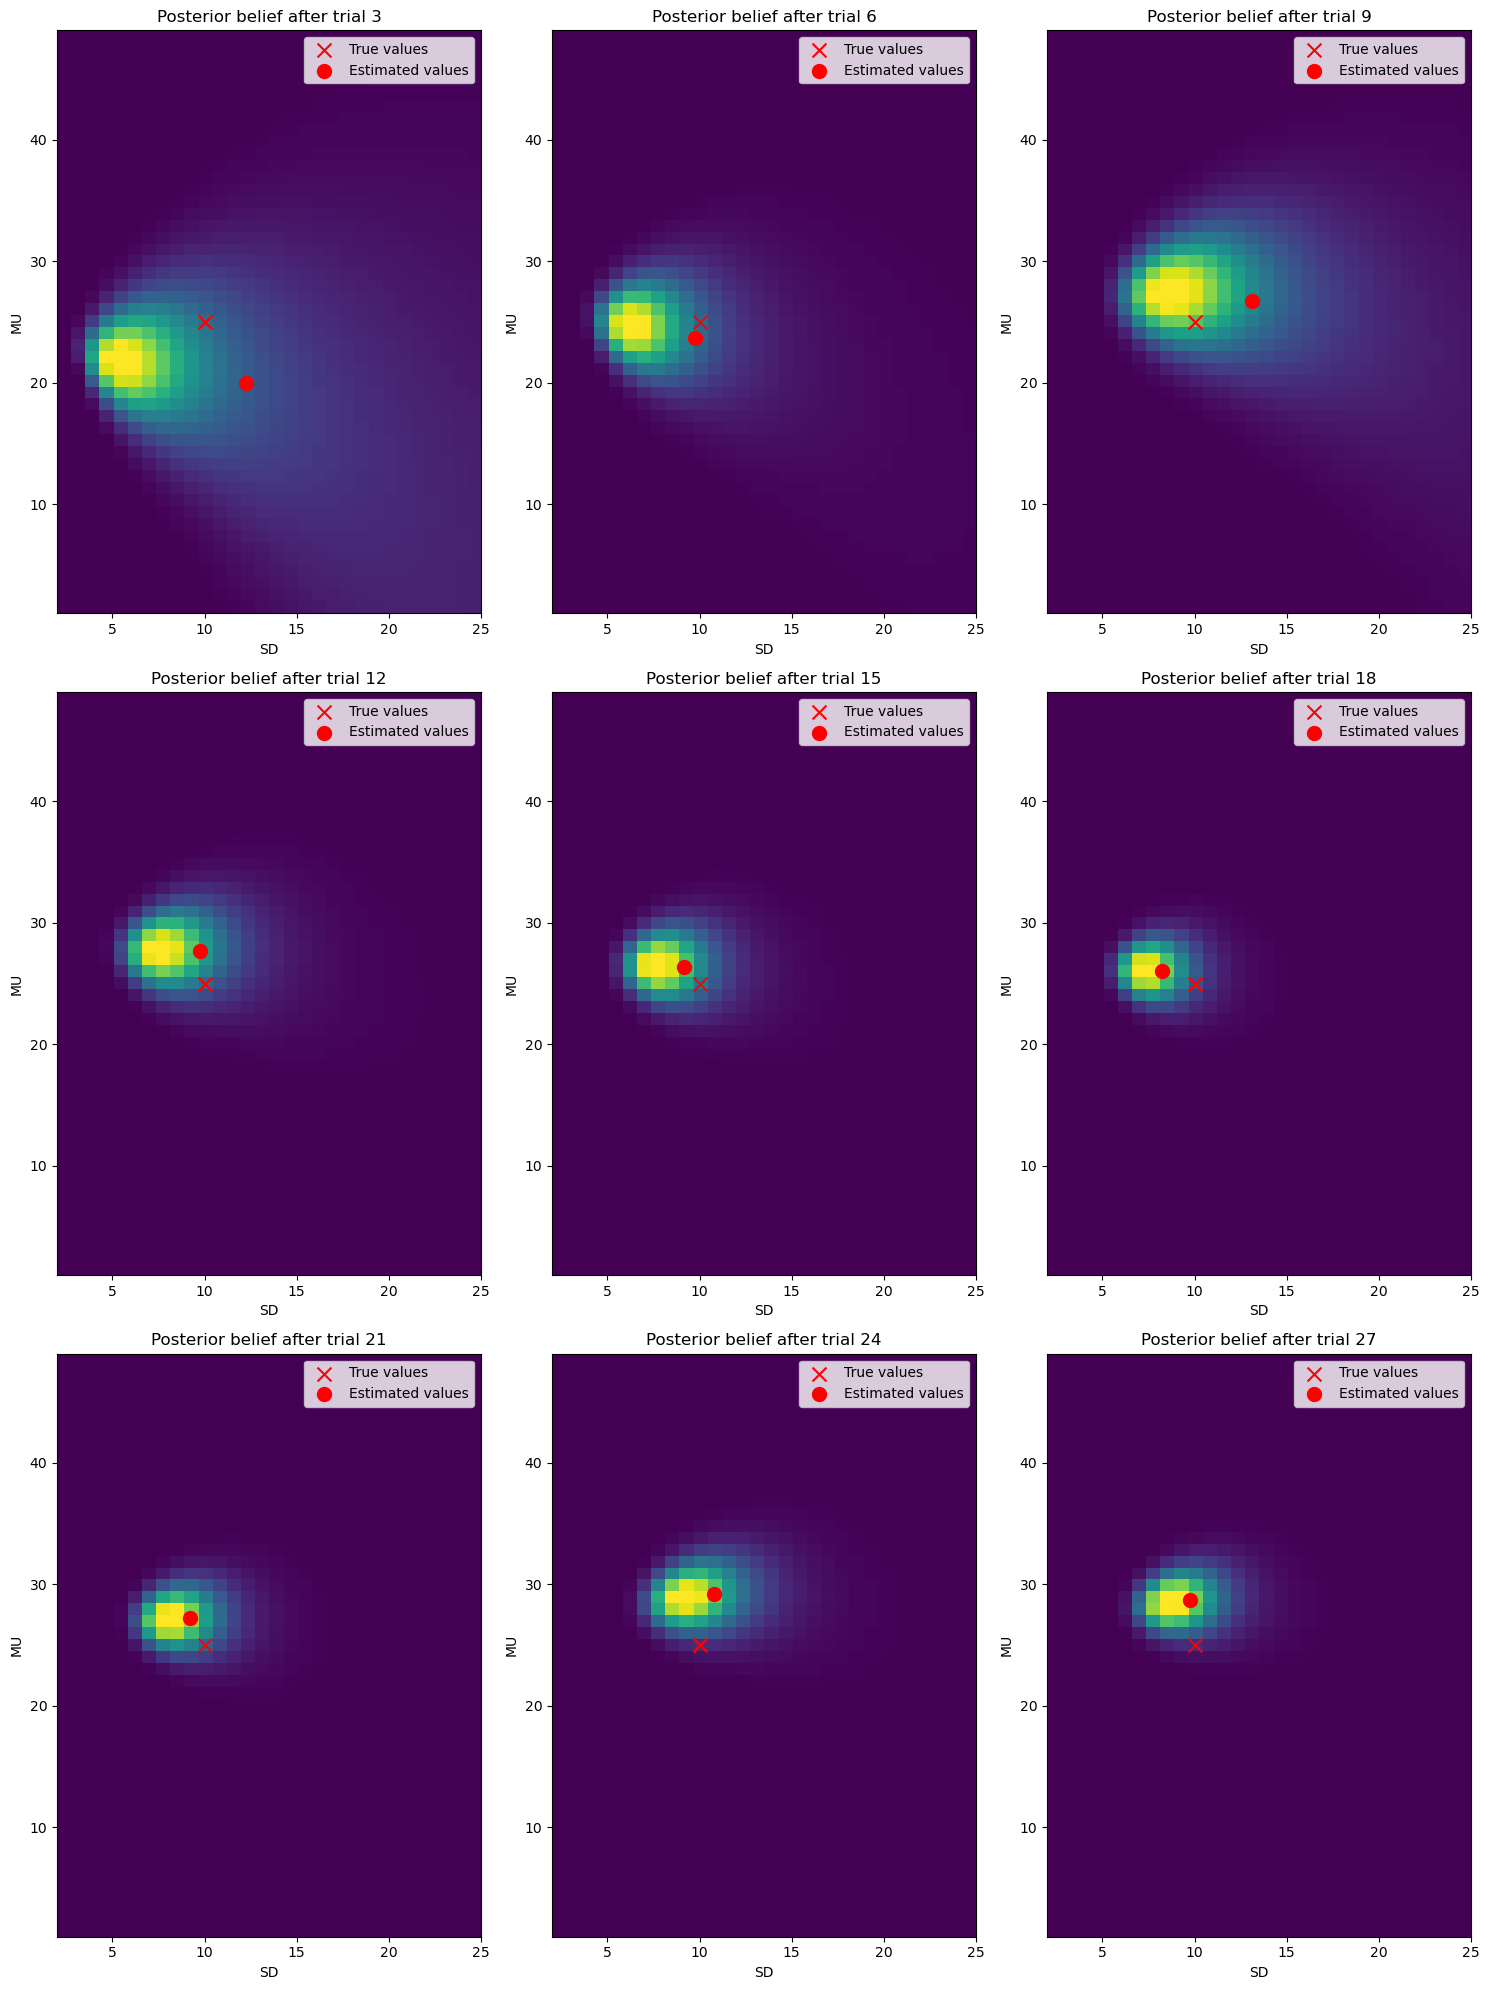

In [244]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_posterior(posterior, possible_mus, possible_sds):
    posterior[posterior < 1e-9] = 1e-9  # Avoid extremely small values

    norm = np.trapz(np.trapz(posterior, possible_mus, axis=0), possible_sds, axis=0)

    posterior = posterior / norm

    return posterior

def compute_expected_values(posterior, possible_mus, possible_sds):
    # posterior /= np.sum(posterior)  # Ensure total probability sums to 1

    # Compute marginals
    marginal_mu = np.trapz(posterior, possible_sds, axis=1)
    marginal_sd = np.trapz(posterior, possible_mus, axis=0)

    # Compute expected values
    expected_mu = np.trapz(possible_mus * marginal_mu, possible_mus)
    expected_sd = np.trapz(possible_sds * marginal_sd, possible_sds)

    return expected_mu, expected_sd

def get_likelihood(bursted, x, mus, sds):
    # Calculate p(pop) for each mu, sd combination
    p_pop_on_pump = normal_distribution_discrete_pdf(x, mus, sds) / \
                    (1 - normal_distribution_discrete_cdf(x, mus, sds))

    # Clip likelihoods to valid range
    p_pop_on_pump = np.minimum(p_pop_on_pump, 1)

    # Return likelihood based on burst status
    return np.where(bursted, p_pop_on_pump, 1 - p_pop_on_pump)

def normal_distribution_discrete_pdf(x, mu, sd):
    return np.exp(-0.5 * ((x - mu) / sd)**2) / (sd * np.sqrt(2 * np.pi))

def normal_distribution_discrete_cdf(x, mu, sd):
    from scipy.stats import norm
    return norm.cdf(x, loc=mu, scale=sd)

# Define parameter ranges
possible_mus = np.arange(1, 50)
possible_sds = np.linspace(2, 25, 30)

# Initialize flat prior
prior = np.ones((len(possible_mus), len(possible_sds)))
prior = normalize_posterior(prior, possible_mus, possible_sds)

generating_mu = 25
generating_sd = 10
max_n_pumps = 35

# Visualization setup
plt.figure(figsize=(15, 20))
posterior = prior.copy()

step_size = 3
n_trials = step_size*9

for trial in range(1, n_trials+1):

    burst_on = np.clip(int(norm(generating_mu, generating_sd).rvs()), 1, 99)

    for pump in range(max_n_pumps):
        bursted = pump == burst_on

        if bursted:
            ll = get_likelihood(True, pump, possible_mus[:, np.newaxis], possible_sds[np.newaxis, :])
            posterior = normalize_posterior(posterior * ll, possible_mus, possible_sds)
            print(f'Bursted after {pump} pumps')
            break
        else:
            ll = get_likelihood(False, pump, possible_mus[:, np.newaxis], possible_sds[np.newaxis, :])
            posterior = normalize_posterior(posterior * ll, possible_mus, possible_sds)

    if trial % step_size == 0:
        plt.subplot(3, 3, int(trial / step_size + 1) - 1)
        plt.imshow(
            posterior / np.max(posterior),
            extent=(possible_sds[0], possible_sds[-1], possible_mus[0], possible_mus[-1]),
            origin='lower',
            aspect='auto',
            cmap='viridis',
            vmin=0,
            vmax=prior[0, 0] * 1000,

        )

        plt.xlabel('SD')
        plt.ylabel('MU')

        expected_mu, expected_sd = compute_expected_values(posterior, possible_mus, possible_sds)

        # Mark true and estimated values
        plt.scatter([generating_sd], [generating_mu], c='r', s=100, marker='x', label='True values')
        plt.scatter([expected_sd], [expected_mu], c='r', s=100, marker='o', label='Estimated values')
        plt.title(f'Posterior belief after trial {trial}')
        plt.legend()

plt.tight_layout()
plt.show()


In [199]:
posterior

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [173]:
posterior

array([[2.74420160e-04, 3.78974075e-04, 3.49570453e-04, 8.19405674e-05,
        3.50602805e-05, 6.18527241e-03, 4.86612463e-02, 8.31135264e-02,
        8.65636930e-02, 1.37181541e-01, 1.88806370e-01, 2.42312268e-01,
        3.05204459e-01, 3.42448396e-01, 1.74780996e-01, 1.61393245e-01,
        1.00630581e-01, 3.95575134e-02, 2.04044126e-02, 1.43535075e-02,
        1.20000468e-02, 1.17303512e-02, 1.32166662e-02, 1.55128791e-02,
        1.54986169e-02, 1.46395922e-02, 1.34416012e-02, 1.16382124e-02,
        8.84228070e-03, 4.65708409e-03],
       [2.98693115e-04, 4.14098215e-04, 3.81969402e-04, 8.95349970e-05,
        3.83097434e-05, 4.61297374e-02, 1.12562734e-01, 1.26633201e-01,
        1.31469304e-01, 1.81022325e-01, 2.16900582e-01, 2.40513196e-01,
        2.59448744e-01, 2.65336734e-01, 1.29498281e-01, 1.29217240e-01,
        8.35272976e-02, 3.25904096e-02, 1.66837421e-02, 1.14518224e-02,
        9.62547670e-03, 9.03159595e-03, 1.01852656e-02, 1.16401803e-02,
        1.11590522e-02,

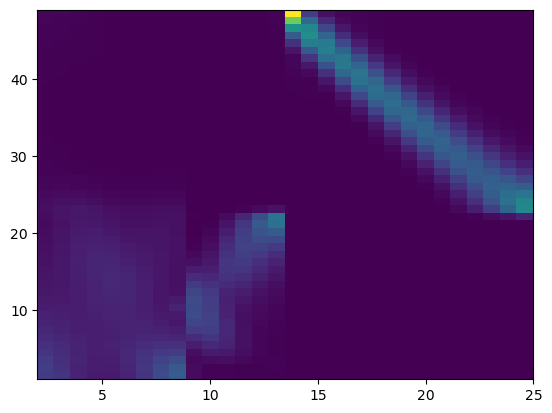

In [196]:
def normalize_posterior(posterior, possible_mus, possible_sds):
    posterior[posterior < 1e-9] = 1e-9  # Avoid extremely small values
    norm_mus = np.trapz(posterior, possible_mus, axis=0)
    norm_mus[norm_mus == 0] = 1  # Avoid division by zero
    posterior = posterior / norm_mus[np.newaxis, :]

    norm_sds = np.trapz(posterior, possible_sds, axis=1)
    norm_sds[norm_sds == 0] = 1  # Avoid division by zero
    posterior = posterior / norm_sds[:, np.newaxis]
    return posterior

def compute_expected_values(posterior, possible_mus, possible_sds):
    posterior /= np.sum(posterior)  # Ensure normalization
    marginal_mu = np.trapz(posterior, possible_sds, axis=1)
    marginal_sd = np.trapz(posterior, possible_mus, axis=0)

    expected_mu = np.trapz(possible_mus * marginal_mu, possible_mus)
    expected_sd = np.trapz(possible_sds * marginal_sd, possible_sds)
    return expected_mu, expected_sd

# Visualization adjustments
plt.imshow(
    posterior / np.max(posterior),  # Normalize for consistent scaling
    extent=(possible_sds[0], possible_sds[-1], possible_mus[0], possible_mus[-1]),
    origin='lower',
    aspect='auto',
    cmap='viridis'
)
